# Space Images Classifier - Using Kaggle dataset

https://www.kaggle.com/datasets/abhikalpsrivastava15/space-images-category?utm_source=chatgpt.com

# Import librairies

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import cv2
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight

# Settings to optimize M1 Chip

In [2]:
# ============================================================================
# Configuration optimized for M1 Chip
# ============================================================================
print("=" * 80 + "\n")
print("Optimized parameters for M1 Chip")
print("=" * 80 + "\n")

print(f"TensorFlow version: {tf.__version__}")

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"M1 GPU detected: {len(gpus)} device(s)")
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("Running on CPU")

# Set seeds for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

print("\n" + "=" * 80)

# ============================================================================
# Optimized parameters for M1 Chip - 16Go RAM
# ============================================================================
print("Optimized parameters for M1 Chip")
print("=" * 80 + "\n")

# Memory-optimized settings
PREFETCH_SIZE = tf.data.AUTOTUNE  # Auto-optimize data loading
NUM_PARALLEL_CALLS = tf.data.AUTOTUNE  # Use all CPU cores

print(f"Auto-tuned prefetching: ENABLED")
print(f"Parallel data loading: ENABLED")


Optimized parameters for M1 Chip

TensorFlow version: 2.16.2
M1 GPU detected: 1 device(s)

Optimized parameters for M1 Chip

Auto-tuned prefetching: ENABLED
Parallel data loading: ENABLED


# Data configuration

In [3]:
print("=" * 80)

ORIGINAL_DATA_PATH = Path("../space-images-category")
OUTPUT_PATH = Path("../space_images_split")

# Split ratios for training, validation and test sets
TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
TEST_RATIO = 0.15

# Model parameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS_STAGE1 = 25
EPOCHS_STAGE2 = 15

print(f"Original dataset: {ORIGINAL_DATA_PATH}")
print(f"Split dataset: {OUTPUT_PATH}")
print(f"Split ratios: Train={TRAIN_RATIO}, Val={VAL_RATIO}, Test={TEST_RATIO}")
print(f"Random seed: {SEED} (for reproducibility)")
print("=" * 80)

Original dataset: ../space-images-category
Split dataset: ../space_images_split
Split ratios: Train=0.7, Val=0.15, Test=0.15
Random seed: 42 (for reproducibility)


In [4]:
print(os.getcwd())

/Users/photoli93/Desktop/Projets perso Python/astro_img_classification/notebooks


Found 6 classes: ['constellation', 'cosmos space', 'galaxies', 'nebula', 'planets', 'stars']
Created directory structure
Splitting images (seed=42 for reproducibility)


Processing classes: 100%|██████████| 6/6 [00:01<00:00,  5.10it/s]



Overview split summary
--------------------------------------------------------------------------------
        class  total  train  validation  test  train_pct   val_pct  test_pct
constellation    183    128          27    28  69.945355 14.754098 15.300546
 cosmos space    166    116          24    26  69.879518 14.457831 15.662651
     galaxies    237    165          35    37  69.620253 14.767932 15.611814
       nebula    170    118          25    27  69.411765 14.705882 15.882353
      planets    176    123          26    27  69.886364 14.772727 15.340909
        stars    175    122          26    27  69.714286 14.857143 15.428571
Split summary saved: ../space_images_split/split_summary.csv
Verifying that there is no data leaking
Verified : No overlap between train/val/test sets


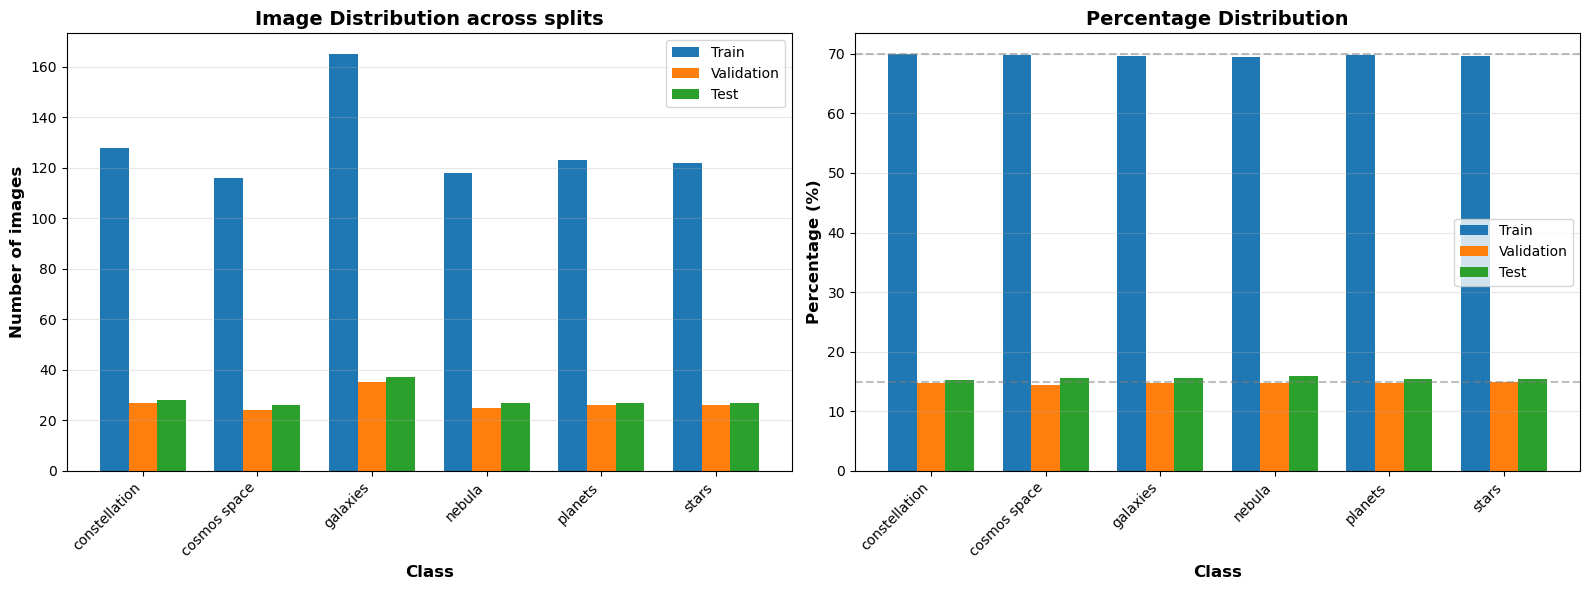

Split visualization saved: ../space_images_split/split_visualization.png
Data split complete with no data leaking


In [12]:
# ============================================================================
# Phase 1: Create Train/Val/Test folders (Only executed once)
# ============================================================================

def create_train_val_test_split(original_path, output_path, train_ratio, val_ratio, test_ratio, seed=42):
    """
    Create stratified train/validation/test split
    
    This function:
    1. Preserves class distribution in all splits
    2. Ensures no overlapping between train/val/test
    3. Creates separate directories for each split
    4. Is reproducible (same split every time with same seed)
    """
    
    if not original_path.exists():
        print(f"Error : Dataset not found at {original_path}")
        print("Please download from: https://www.kaggle.com/datasets/abhikalpsrivastava15/space-images-category")
        return False
    
    # Check if split already exists
    if output_path.exists():
        response = input(f"{output_path} already exists. Recreate split? [YES/NO]: ")
        if response.lower() != 'yes':
            print("Using existing split")
            return True
        shutil.rmtree(output_path)
    
    # Get all classes
    classes = sorted([d.name for d in original_path.iterdir() if d.is_dir()])
    
    if not classes:
        print("Error : No class folders found in dataset")
        return False
    
    print('=' * 80)
    print(f"Found {len(classes)} classes: {classes}")

    # Create output directories
    train_path = output_path / "train"
    val_path = output_path / "validation"
    test_path = output_path / "test"
    
    for split_path in [train_path, val_path, test_path]:
        for cls in classes:
            (split_path / cls).mkdir(parents=True, exist_ok=True)
    
    print(f"Created directory structure")
    
    # Split each class
    split_summary = []
    
    print(f"Splitting images (seed={seed} for reproducibility)")

    # Loop through classes with progress bar
    for cls in tqdm(classes, desc="Processing classes"):
        cls_path = original_path / cls
        
        # Get all images
        images = []
        for ext in ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']:
            images.extend(list(cls_path.glob(ext)))
        
        if not images:
            print(f"No images found for class: {cls}")
            continue
        
        # Shuffle with seed for reproducibility
        np.random.seed(seed)
        images = np.array(images)
        np.random.shuffle(images)
        
        # Calculate split indices
        n_total = len(images)
        n_train = int(n_total * train_ratio)
        n_val = int(n_total * val_ratio)
        n_test = n_total - n_train - n_val
        
        # Split images
        train_images = images[:n_train]
        val_images = images[n_train:n_train+n_val]
        test_images = images[n_train+n_val:]
        
        # Copy images to respective folders
        for img in train_images:
            shutil.copy2(img, train_path / cls / img.name)
        
        for img in val_images:
            shutil.copy2(img, val_path / cls / img.name)
        
        for img in test_images:
            shutil.copy2(img, test_path / cls / img.name)
        
        split_summary.append({
            'class': cls,
            'total': n_total,
            'train': n_train,
            'validation': n_val,
            'test': n_test,
            'train_pct': n_train/n_total*100,
            'val_pct': n_val/n_total*100,
            'test_pct': n_test/n_total*100
        })
    
    # Display summary
    df_summary = pd.DataFrame(split_summary)
    print(f"\n{'=' * 80}")
    print("Overview split summary")
    print('-' * 80)
    print(df_summary.to_string(index=False))
    print('=' * 80)

    # Save summary
    df_summary.to_csv(output_path / 'split_summary.csv', index=False)
    print(f"Split summary saved: {output_path / 'split_summary.csv'}")
    
    # Verify no overlap
    print("Verifying that there is no data leaking")
    train_files = set([f.name for f in (train_path / classes[0]).glob("*")])
    val_files = set([f.name for f in (val_path / classes[0]).glob("*")])
    test_files = set([f.name for f in (test_path / classes[0]).glob("*")])
    
    overlap_train_val = train_files & val_files
    overlap_train_test = train_files & test_files
    overlap_val_test = val_files & test_files
    
    if overlap_train_val or overlap_train_test or overlap_val_test:
        print("Warning : Data leaking detected")
    else:
        print("Verified : No overlap between train/val/test sets")
        print('=' * 80)
    
    # Visualize split distribution
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Absolute counts
    x = np.arange(len(classes))
    width = 0.25
    
    axes[0].bar(x - width, df_summary['train'], width, label='Train')
    axes[0].bar(x, df_summary['validation'], width, label='Validation')
    axes[0].bar(x + width, df_summary['test'], width, label='Test')
    axes[0].set_xlabel('Class', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Number of images', fontsize=12, fontweight='bold')
    axes[0].set_title('Image Distribution across splits', fontsize=14, fontweight='bold')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(classes, rotation=45, ha='right')
    axes[0].legend()
    axes[0].grid(axis='y', alpha=0.3)
    
    # Percentages
    axes[1].bar(x - width, df_summary['train_pct'], width, label='Train')
    axes[1].bar(x, df_summary['val_pct'], width, label='Validation')
    axes[1].bar(x + width, df_summary['test_pct'], width, label='Test')
    axes[1].set_xlabel('Class', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Percentage (%)', fontsize=12, fontweight='bold')
    axes[1].set_title('Percentage Distribution', fontsize=14, fontweight='bold')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(classes, rotation=45, ha='right')
    axes[1].legend()
    axes[1].grid(axis='y', alpha=0.3)
    axes[1].axhline(y=70, color='gray', linestyle='--', alpha=0.5)
    axes[1].axhline(y=15, color='gray', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.savefig(output_path / 'split_visualization.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print('=' * 80)
    print(f"Split visualization saved: {output_path / 'split_visualization.png'}")
    print("Data split complete with no data leaking")
    print('=' * 80)
    
    return True

# Create the split
split_success = create_train_val_test_split(
    ORIGINAL_DATA_PATH, 
    OUTPUT_PATH, 
    TRAIN_RATIO, 
    VAL_RATIO, 
    TEST_RATIO, 
    SEED
)

# Data loading Data Generators